# Covariate Shift Detection in diabetes prediction task

## Introduction
This notebook demonstrates the process of training an XGBoost model to predict diabetes. Additionally, we simulate covariate shifts in some important features and use the Detectron method to detect these shifts using different statistical tests. 


## Data Preparation

**1. Import Necessary Libraries**  

We start by importing the essential libraries for our experiment. These libraries include:
- `pandas` for data manipulation and analysis.
- `sklearn.model_selection` for splitting the dataset.
- `sklearn.preprocessing` for feature scaling.

**2. Load the Dataset**  

We load the diabetes dataset from a CSV file named `diabetes.csv`.

**3. Check for Missing Values**  

To ensure data quality, we check for any missing values in the dataset and display the count of missing values for each column.

**4. Split the Data into Features and Target**  

We separate the features (X) from the target variable (y). The target variable is 'Outcome', which indicates the presence of diabetes.

**5. Split the Data into Train, Validation, and Test Sets**  

We split the data into training, validation, and test sets using a two-step process:
1. Split the data into 70% training and 30% temporary (X_temp, y_temp).
2. Further split the temporary set into 50% validation and 50% test sets.

**6. Feature Scaling**  

We standardize the features by removing the mean and scaling to unit variance. This is done to ensure that the features have similar scales, which helps in model training.

**7. Save the Datasets as CSV Files**  

We save the obtained DataFrames as CSV files for training, validation, and testing.


In [1]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load the dataset
# The dataset is loaded from a CSV file named 'diabetes.csv'
data = pd.read_csv('./datasets/diabetes.csv')

# Check for missing values
# Display the count of missing values in each column
print(data.isnull().sum())

# Split the data into features and target
# Separate the features (X) from the target (y)
X = data.drop(columns=['Outcome'])
y = data['Outcome']

# Split the data into train, validation, and test sets
# The data is split into 70% training and 30% temporary (X_temp, y_temp)
# The temporary set is further split into 50% validation and 50% test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Feature scaling
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames and reset indices
# Convert the scaled arrays to DataFrames and reset their indices for consistency
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns).reset_index(drop=True)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X.columns).reset_index(drop=True)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns).reset_index(drop=True)

# Reset indices of the target variables
y_train_df = y_train.reset_index(drop=True)
y_val_df = y_val.reset_index(drop=True)
y_test_df = y_test.reset_index(drop=True)

# Save the datasets as CSV files
# Combine the scaled feature DataFrames with their corresponding target variables
# Save the combined DataFrames as CSV files for training, validation, and testing
train_data = pd.concat([X_train_scaled_df, y_train_df], axis=1)
val_data = pd.concat([X_val_scaled_df, y_val_df], axis=1)
test_data = pd.concat([X_test_scaled_df, y_test_df], axis=1)
train_data.to_csv('./datasets/train_data.csv', index=False)
val_data.to_csv('./datasets/val_data.csv', index=False)
test_data.to_csv('./datasets/test_data.csv', index=False)


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


## Model Training and Evaluation

**Create a DMatrix for Training, Validation, and Test Data**    

We use XGBoost's `DMatrix` for training, validation, and test data. `DMatrix` is an optimized data structure that XGBoost uses for efficient training and prediction.

**Set Hyperparameters for the XGBoost Model**  

We set the hyperparameters for the XGBoost model based on a hyperparameter tuning process. The parameters include:
- `colsample_bytree`: Subsample ratio of columns when constructing each tree.
- `gamma`: Minimum loss reduction required to make a further partition on a leaf node of the tree.
- `learning_rate`: Step size shrinkage used in update to prevent overfitting.
- `max_depth`: Maximum depth of a tree.
- `subsample`: Subsample ratio of the training instances.
- `eval_metric`: Evaluation metric used to monitor the training performance.

**Train the Model with the Best Parameters**  

We train the XGBoost model with the defined parameters using 100 boosting rounds. Early stopping is applied with 10 rounds to prevent overfitting.

**Evaluate the Model on the Test Set**  

We evaluate the trained model on the test set using the following metrics:
- `Accuracy`: The proportion of correctly classified instances.
- `ROC AUC`: The area under the receiver operating characteristic curve.
- `Log Loss`: The negative log-likelihood of the true labels given the predicted probabilities.

**Save the Model**  

We save the trained model in JSON format and also use `pickle` to serialize the model for future use.


In [2]:
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
import xgboost as xgb
import pickle

# Create a DMatrix for training, validation, and test data
# DMatrix is an optimized data structure that XGBoost uses to train and predict
dtrain = xgb.DMatrix(data=X_train_scaled, label=y_train)
dval = xgb.DMatrix(data=X_val_scaled, label=y_val)
dtest = xgb.DMatrix(data=X_test_scaled, label=y_test)

# Set the hyperparameters for the XGBoost model
params = {"colsample_bytree": 0.8247176589617523, 
          "gamma": 0.30255939244569324, 
          "learning_rate": 0.07102942639067696, 
          "max_depth": 9, 
          "subsample": 0.8171213407907597, 
          "eval_metric": "auc"}

num_round = 100  # Number of boosting rounds
# Train the model with the best parameters
evallist = [(dval, 'eval')]  # Evaluation set
bst = xgb.train(params, dtrain, num_round, evals=evallist, early_stopping_rounds=10)

# Evaluate the model on the test set
preds = bst.predict(dtest)  # Predict probabilities
predictions = [round(value) for value in preds]  # Convert probabilities to binary predictions

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, preds)
logloss = log_loss(y_test, preds)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Log Loss: {logloss:.4f}")

# Save the model in JSON format
bst.save_model('./models/diabetes_xgb_model.json')
print("Model trained and evaluated successfully!")

# Save the model using pickle
with open('./models/diabetes_xgb_model.pkl', 'wb') as f:
    pickle.dump(bst, f)


[0]	eval-auc:0.66771
[1]	eval-auc:0.72332
[2]	eval-auc:0.75901
[3]	eval-auc:0.76975
[4]	eval-auc:0.76386
[5]	eval-auc:0.76698
[6]	eval-auc:0.76091
[7]	eval-auc:0.77062
[8]	eval-auc:0.76784
[9]	eval-auc:0.76646
[10]	eval-auc:0.76369
[11]	eval-auc:0.76923
[12]	eval-auc:0.77755
[13]	eval-auc:0.77755
[14]	eval-auc:0.77581
[15]	eval-auc:0.78170
[16]	eval-auc:0.78933
[17]	eval-auc:0.78760
[18]	eval-auc:0.78621
[19]	eval-auc:0.79071
[20]	eval-auc:0.78621
[21]	eval-auc:0.78725
[22]	eval-auc:0.78933
[23]	eval-auc:0.78586
[24]	eval-auc:0.78517
[25]	eval-auc:0.78552
[26]	eval-auc:0.78552
[27]	eval-auc:0.78725
[28]	eval-auc:0.78552
Accuracy: 0.7845
ROC AUC: 0.8214
Log Loss: 0.5025
Model trained and evaluated successfully!


## Features Importance

**Get Feature Importances**  

We retrieve the feature importances from the trained XGBoost model using the `get_score` method with the importance type set to 'weight'. This indicates the number of times a feature appears in the trees.

**Sort Features by Importance**  

The features are sorted by their importance in descending order to identify the most influential features.

The top three most important features are:
- `Glucose`
- `BMI`
- `DiabetesPedigreeFunction`

In [3]:
feature_importances = bst.get_score(importance_type='weight')

# Sort features by importance
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
sorted_features

[('f1', 116.0),
 ('f5', 115.0),
 ('f6', 103.0),
 ('f2', 85.0),
 ('f7', 80.0),
 ('f4', 72.0),
 ('f0', 64.0),
 ('f3', 43.0)]

## Simulating Covariate Shift and Model Evaluation

**1. Load the Model**  

We begin by loading the pre-trained XGBoost model from a pickle file.

**2. Function to Simulate Covariate Shift**  

We define a function `simulate_covariate_shift` to add Gaussian noise to selected features in the dataset, simulating a covariate shift. The magnitude of the shift can be controlled by the `shift_magnitude` parameter.

**3. Select Features to Shift**

We select specific features to introduce covariate shift. In this case, we choose the most important features : `Glucose`, `BMI`, and `DiabetesPedigreeFunction`.

**4. Define Shift Magnitudes**  

We define different magnitudes of covariate shift to evaluate the model's robustness against varying degrees of shift. The magnitudes chosen are 0.1, 0.6, and 1.6.

**5. Simulate Covariate Shift and Evaluate the Model**  

For each shift magnitude, we:
1. Simulate the covariate shift on the test set.
2. Scale the shifted test set.
3. Save the shifted test set as a CSV file.
4. Evaluate the model on the shifted test set using accuracy, ROC AUC, and log loss as metrics.
5. Print and store the evaluation metrics.


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
import xgboost as xgb
import pickle


# Load the model
with open('./models/diabetes_xgb_model.pkl', 'rb') as f:
    bst = pickle.load(f)

# Function to simulate covariate shift by adding noise
def simulate_covariate_shift(X, shift_magnitude=0.5, shift_features=None):
    np.random.seed(0)
    if shift_features is None:
        shift_features = X.columns
    
    X_shifted = X.copy()
    for feature in shift_features:
        shift = np.random.normal(loc=0, scale=shift_magnitude, size=X[feature].shape)
        X_shifted[feature] += shift
    
    return X_shifted

# Select features to shift (for example, 'Glucose', 'BMI', 'DiabetesPedigreeFunction')
shift_features = ['Glucose', 'BMI', 'DiabetesPedigreeFunction']

# Define different magnitudes of covariate shift to evaluate
shift_magnitudes = [0.1, 0.6, 1.6]
# Loop through each shift magnitude, simulate the covariate shift, and evaluate the model
results = []

for shift_magnitude in shift_magnitudes:
    # Simulate covariate shift on the test set
    X_test_shifted = simulate_covariate_shift(pd.DataFrame(X_test, columns=X.columns), shift_magnitude=shift_magnitude, shift_features=shift_features)
    
    # Scale the shifted test set
    X_test_shifted_scaled = scaler.transform(X_test_shifted)
    
    # Save the shifted test set as a CSV file
    X_test_shifted_df = pd.DataFrame(X_test_shifted_scaled, columns=X.columns).reset_index(drop=True)
    y_shifted_df = y_test.reset_index(drop=True)
    
    shifted_data = pd.concat([X_test_shifted_df, y_shifted_df], axis=1)
    shifted_data.to_csv(f'./datasets/test_data_shifted_{shift_magnitude}.csv', index=False)
    
    # Evaluate the model on the shifted test set
    dtest_shifted = xgb.DMatrix(data=X_test_shifted_scaled, label=y_test)
    preds_shifted = bst.predict(dtest_shifted)
    predictions_shifted = [round(value) for value in preds_shifted]
    
    # Calculate evaluation metrics for the shifted test set
    accuracy_shifted = accuracy_score(y_test, predictions_shifted)
    roc_auc_shifted = roc_auc_score(y_test, preds_shifted)
    logloss_shifted = log_loss(y_test, preds_shifted)
    
    # Store the results
    results.append({
        'shift_magnitude': shift_magnitude,
        'accuracy': accuracy_shifted,
        'roc_auc': roc_auc_shifted,
        'log_loss': logloss_shifted
    })

# Convert the results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)
print(results_df)


   shift_magnitude  accuracy   roc_auc  log_loss
0              0.1  0.775862  0.821281  0.500970
1              0.6  0.741379  0.804078  0.525841
2              1.6  0.706897  0.781778  0.542697


## Plotting Feature Distributions

We visualize the effect of covariate shift by plotting the distributions of the original and shifted datasets for selected features. This helps in understanding how the feature distributions change with different magnitudes of shift.

**Load the Original and Shifted Datasets**  

We load the original test dataset and the shifted test datasets generated with different shift magnitudes.

**Plot Distributions**  

For each selected feature, we plot the kernel density estimates (KDE) to compare the distribution in the original dataset with the distributions in the shifted datasets.


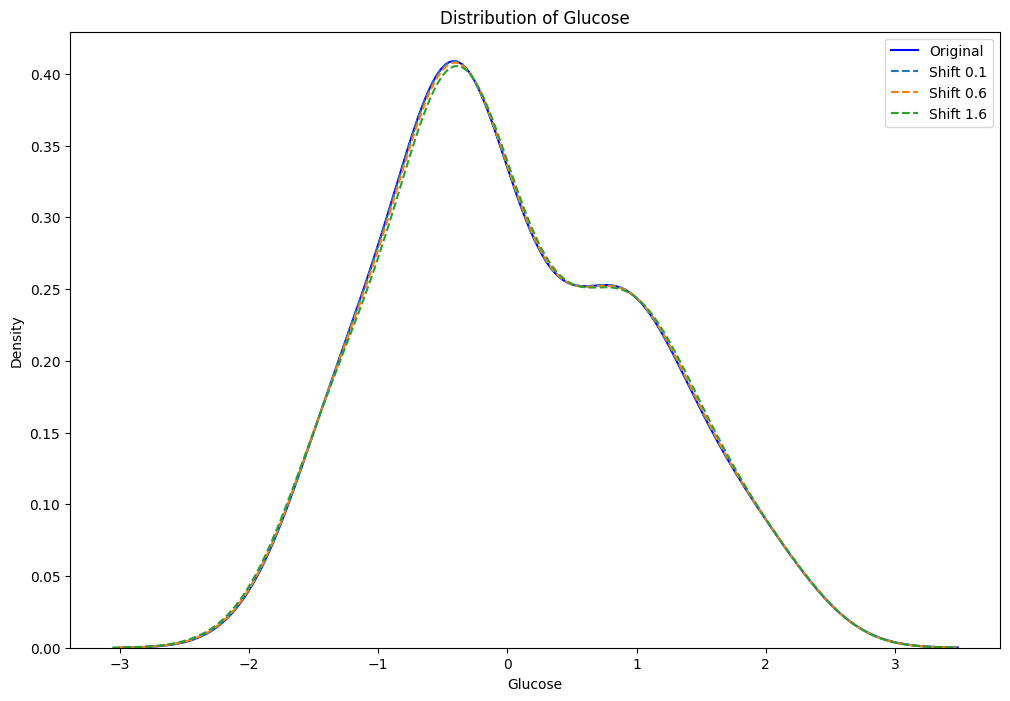

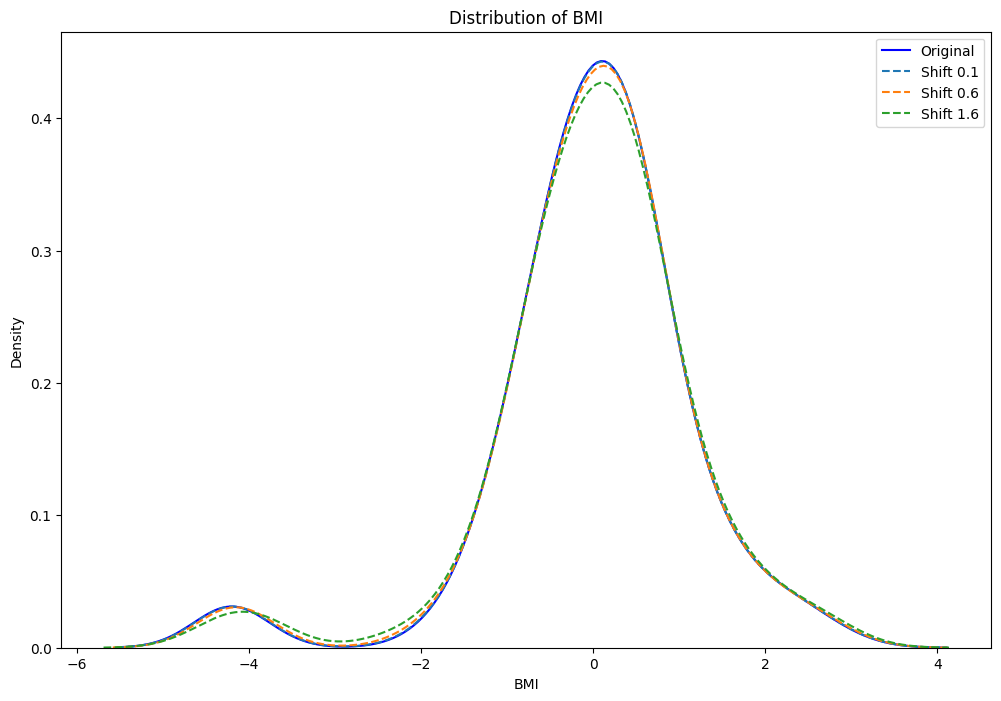

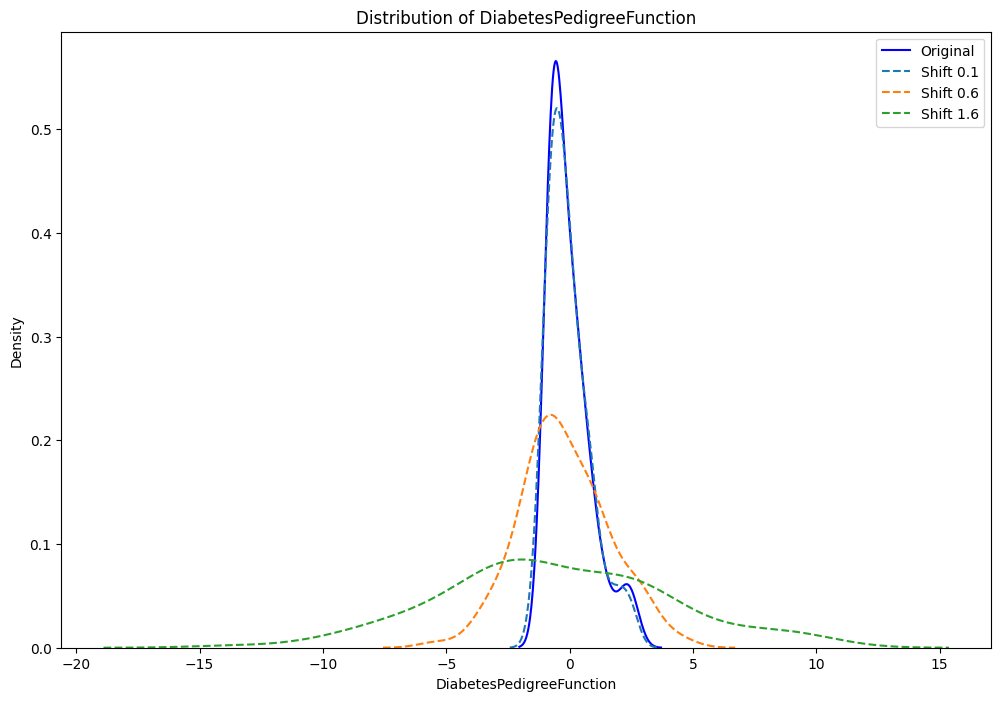

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the original and shifted datasets
original_test = pd.read_csv('./datasets/test_data.csv')
shifted_datasets = {
    0.1: pd.read_csv('./datasets/test_data_shifted_0.1.csv'),
    0.6: pd.read_csv('./datasets/test_data_shifted_0.6.csv'),
    1.6: pd.read_csv('./datasets/test_data_shifted_1.6.csv')
}

# Select features to plot
shift_features = ['Glucose', 'BMI', 'DiabetesPedigreeFunction']

# Plot distributions
for feature in shift_features:
    plt.figure(figsize=(12, 8))
    
    # Plot original dataset distribution
    sns.kdeplot(original_test[feature], label='Original', color='blue')
    
    # Plot shifted datasets distributions
    for shift_magnitude, shifted_data in shifted_datasets.items():
        sns.kdeplot(shifted_data[feature], label=f'Shift {shift_magnitude}', linestyle='--')
    
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()


## Running Detectron Experiment

**Load Necessary Libraries and Modules**  

We begin by importing the necessary libraries and modules required for managing datasets, models, and running the Detectron experiment.

**Prepare Datasets Manager and Model Factory**  

We set up the datasets manager to handle different datasets (training, validation, reference, and testing) and initialize the model factory to create models from pickled files. The base model manager is used to manage the loaded model.

**Loop Through Each Shift Magnitude**  

For each shift magnitude, we:
1. Load the shifted test dataset.
2. Set the shifted test dataset in the datasets manager.
3. Run the Detectron experiment using the datasets and base model manager.
4. Print and store the results of the Detectron analysis using different disagreement strategies (`DisagreementStrategy_MW`, `DisagreementStrategy_z_mean`, and `DisagreementStrategy`).


In [6]:
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from pprint import pprint
from det3pa.datasets import DatasetsManager
from det3pa.models import BaseModelManager, ModelFactory
from det3pa.detectron import DetectronExperiment, MannWhitneyStrategy, OriginalDisagreementStrategy, EnhancedDisagreementStrategy
import pandas as pd

# Define different magnitudes of covariate shift to evaluate
shift_magnitudes = [0.1, 0.6, 1.6]

# Prepare datasets manager and model factory
datasets = DatasetsManager()
datasets.set_from_file("training", "./datasets/train_data.csv", "Outcome")
datasets.set_from_file("validation", "./datasets/val_data.csv", "Outcome")
datasets.set_from_file("reference", "./datasets/test_data.csv", "Outcome")

factory = ModelFactory()
loaded_model = factory.create_model_from_pickled("./models/diabetes_xgb_model.pkl")

bm_manager = BaseModelManager()
bm_manager.set_base_model(loaded_model) 

# Loop through each shift magnitude, read the shifted dataset, and execute Detectron experiment
for shift_magnitude in shift_magnitudes:
    # Load the shifted test set
    shifted_test_file = f'./datasets/test_data_shifted_{shift_magnitude}.csv'
    datasets.set_from_file("testing", shifted_test_file, "Outcome")
    
    # Run Detectron experiment
    detectron_results = DetectronExperiment.run(datasets=datasets, base_model_manager=bm_manager)
    
    # Print and store the results
    print(f"Results for shift magnitude: {shift_magnitude}")
    pprint(detectron_results.analyze_results([OriginalDisagreementStrategy, MannWhitneyStrategy, EnhancedDisagreementStrategy]))



running seeds: 100%|██████████| 100/100 [00:11<00:00,  8.50it/s]


Detectron execution on reference set completed.


running seeds: 100%|██████████| 100/100 [00:13<00:00,  7.54it/s]


Detectron execution on testing set completed.
Results for shift magnitude: 0.1
{'power': 0.03, 'auc': 0.53035, 'N': 20}
[{'Strategy': 'OriginalDisagreementStrategy',
  'baseline_mean': 12.47,
  'baseline_std': 1.920702996301094,
  'p_value': 0.04,
  'test_statistic': 7},
 {'Strategy': 'MannWhitneyStrategy',
  'p_value': 0.22518291651155886,
  'shift significance': 'Small',
  'u_statistic': 4696.5,
  'z-score': 0.08330283250878949},
 {'Strategy': 'EnhancedDisagreementStrategy',
  'baseline_mean': 7.4,
  'baseline_std': 1.2631530214330944,
  'shift_probability': 0.5777777777777777,
  'significance_description': {'large': 12.91358024691358,
                               'moderate': 12.506172839506172,
                               'no shift': 56.148148148148145,
                               'small': 18.432098765432098},
  'test_statistic': 7.6}]


running seeds: 100%|██████████| 100/100 [00:11<00:00,  8.97it/s]


Detectron execution on reference set completed.


running seeds: 100%|██████████| 100/100 [00:13<00:00,  7.47it/s]


Detectron execution on testing set completed.
Results for shift magnitude: 0.6
{'power': 0.21250000000000002, 'auc': 0.6681000000000001, 'N': 20}
[{'Strategy': 'OriginalDisagreementStrategy',
  'baseline_mean': 12.71,
  'baseline_std': 1.8237050200073475,
  'p_value': 0.02,
  'test_statistic': 7},
 {'Strategy': 'MannWhitneyStrategy',
  'p_value': 1.6597615361841453e-05,
  'shift significance': 'Small',
  'u_statistic': 3319.0,
  'z-score': 0.6251010922782932},
 {'Strategy': 'EnhancedDisagreementStrategy',
  'baseline_mean': 7.2444444444444445,
  'baseline_std': 1.2230300360726236,
  'shift_probability': 0.8555555555555555,
  'significance_description': {'large': 30.925925925925924,
                               'moderate': 17.40740740740741,
                               'no shift': 36.098765432098766,
                               'small': 15.567901234567902},
  'test_statistic': 8.466666666666667}]


running seeds: 100%|██████████| 100/100 [00:10<00:00,  9.89it/s]


Detectron execution on reference set completed.


running seeds: 100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Detectron execution on testing set completed.
Results for shift magnitude: 1.6
{'power': 0.45666666666666667, 'auc': 0.81095, 'N': 20}
[{'Strategy': 'OriginalDisagreementStrategy',
  'baseline_mean': 12.69,
  'baseline_std': 1.9062790981385698,
  'p_value': 0.04,
  'test_statistic': 8},
 {'Strategy': 'MannWhitneyStrategy',
  'p_value': 8.227042449197139e-15,
  'shift significance': 'Moderate',
  'u_statistic': 1890.5,
  'z-score': 1.24850553222978},
 {'Strategy': 'EnhancedDisagreementStrategy',
  'baseline_mean': 7.222222222222222,
  'baseline_std': 1.2541289830686633,
  'shift_probability': 0.9777777777777777,
  'significance_description': {'large': 52.20987654320987,
                               'moderate': 16.82716049382716,
                               'no shift': 17.80246913580247,
                               'small': 13.160493827160494},
  'test_statistic': 9.722222222222221}]


The experiment results are as follows : 
| Shift Magnitude| Original Disagreement Test results | Mann Whitney test results | Improved Disagreement results
|----------|----------|----------|----------|
| 0.1 | p-value : 0.04 | p-value: 0.22 <br> shift significanc: Small | shift probability: 0.57 <br> shift significance: 56% not significant, 18% small, 12% large and moderate |
| 0.6 | p-value : 0.02 | p-value: 1.6e-5 <br> shift significanc: Small | shift probability: 0.85 <br> shift significance: 36% not significant shift, 30% large, 17% small, 15% moderate |
| 1.6 | p-value : 0.04 | p-value: 8.2e-15 <br> shift significanc: Moderate | shift probability: 0.97 <br> shift significance: 52% Large, 17% modereate, 16% not significant, 13% small |

## Conclusion
The results of the Mann Whitney test and the improved disagreement test align better with the shift magnitude, indicating more nuanced and accurate assessments of shift significance. The improved disagreement test, in particular, provides a more comprehensive view by detailing the percentage of not significant, small, moderate, and large shifts.

## Shifted Profiles detection
In this part of the notebook we will simulate a covariate shift on a specific profile from the test dataset, and then run the Med3paDetectron Experiment to detect the presence of a covariate shift in the profiles

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
import xgboost as xgb
import pickle

# Load the dataset
file_path = './datasets/test_data.csv'
data = pd.read_csv(file_path)

# Calculate the mode for the DiabetesPedigreeFunction feature
mode_age = data['Age'].mode().iloc[0]


# Define the condition for the most common DiabetesPedigreeFunction with a tolerance range
condition_dpf = (
    (data['Age'] > -0.47749535739421844) 
)
# Extract the data based on the condition
most_frequent_dpf = data[condition_dpf]
# Extract the rest of the data
rest_of_data = data[~condition_dpf]

# Load the model
with open('./models/diabetes_xgb_model.pkl', 'rb') as f:
    bst = pickle.load(f)

# Function to simulate covariate shift by adding noise
def simulate_covariate_shift(X, shift_magnitude=0.5, shift_features=None):
    np.random.seed(0)
    if shift_features is None:
        shift_features = X.columns
    
    X_shifted = X.copy()
    for feature in shift_features:
        shift = np.random.normal(loc=0, scale=shift_magnitude, size=X[feature].shape)
        X_shifted[feature] += shift
    
    return X_shifted

# Select features to shift (for example, 'Glucose', 'BMI', 'DiabetesPedigreeFunction')
shift_features = ['Glucose', 'BMI', 'DiabetesPedigreeFunction']

# Define different magnitudes of covariate shift to evaluate
shift_magnitudes = [0.1, 0.6, 1.6]

# Loop through each shift magnitude, simulate the covariate shift, and evaluate the model
results = []

# Assuming X_test and y_test are your test features and labels
X = most_frequent_dpf.drop(columns='Outcome')
y = most_frequent_dpf['Outcome']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for shift_magnitude in shift_magnitudes:
    # Simulate covariate shift on the most frequent profile data
    X_shifted = simulate_covariate_shift(pd.DataFrame(X_scaled, columns=X.columns), shift_magnitude=shift_magnitude, shift_features=shift_features)
    
    # Scale the shifted data
    X_shifted_scaled = scaler.transform(X_shifted)
    
    # Combine the shifted data with the rest of the original data
    X_shifted_df = pd.DataFrame(X_shifted_scaled, columns=X.columns).reset_index(drop=True)
    y_shifted_df = y.reset_index(drop=True)
    
    shifted_profile_data = pd.concat([X_shifted_df, y_shifted_df], axis=1)
    combined_data = pd.concat([shifted_profile_data, rest_of_data], ignore_index=True)
    
    # Save the combined data as a CSV file
    combined_data.to_csv(f'./datasets/test_data_shifted_{shift_magnitude}_profiled.csv', index=False)
    
    # Evaluate the model on the combined data
    dtest_combined = xgb.DMatrix(data=combined_data.drop(columns='Outcome'), label=combined_data['Outcome'])
    preds_combined = bst.predict(dtest_combined)
    predictions_combined = [round(value) for value in preds_combined]
    
    # Calculate evaluation metrics for the combined data
    accuracy_combined = accuracy_score(combined_data['Outcome'], predictions_combined)
    roc_auc_combined = roc_auc_score(combined_data['Outcome'], preds_combined)
    logloss_combined = log_loss(combined_data['Outcome'], preds_combined)
    
    # Store the results
    results.append({
        'shift_magnitude': shift_magnitude,
        'accuracy': accuracy_combined,
        'roc_auc': roc_auc_combined,
        'log_loss': logloss_combined
    })

# Convert the results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)
print(results_df)


   shift_magnitude  accuracy   roc_auc  log_loss
0              0.1  0.724138  0.733355  0.611080
1              0.6  0.741379  0.743071  0.602146
2              1.6  0.715517  0.735903  0.598544


In this part, we run the DetectronMed3pa Experiment. Which will build a tree of data profiles according to the confidence level of the model when predicting on these profiles. For each profile we run the detectron experiment to detect if any covariate shift is present.

In [10]:
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from pprint import pprint
from det3pa.datasets import DatasetsManager
from det3pa.models import BaseModelManager, ModelFactory
from det3pa.med3pa import Med3paDetectronExperiment
from det3pa.detectron.strategies import *
import pandas as pd

# Define different magnitudes of covariate shift to evaluate
shift_magnitudes = [0.1, 0.6, 1.6]

# Prepare datasets manager and model factory
datasets = DatasetsManager()
datasets.set_from_file("training", "./datasets/train_data.csv", "Outcome")
datasets.set_from_file("validation", "./datasets/val_data.csv", "Outcome")
datasets.set_from_file("reference", "./datasets/test_data.csv", "Outcome")

factory = ModelFactory()
loaded_model = factory.create_model_from_pickled("./models/diabetes_xgb_model.pkl")

bm_manager = BaseModelManager()
#bm_manager.set_base_model(loaded_model) 

# Loop through each shift magnitude, read the shifted dataset, and execute Detectron experiment
for shift_magnitude in shift_magnitudes:
    # Load the shifted test set
    shifted_test_file = f'./datasets/test_data_shifted_{shift_magnitude}.csv'
    datasets.set_from_file("testing", shifted_test_file, "Outcome")
    
    # Run Detectron experiment
    ref_results, test_results, detectron_results = Med3paDetectronExperiment.run(datasets=datasets, base_model_manager=bm_manager, samples_ratio_min=1, samples_ratio_max=1, samples_ratio_step=2)

    ref_path = f'./results/med3pa_reference_set_results_profiles_{shift_magnitude}_ref'
    test_path = f'./results/med3pa_test_set_results_profiles_{shift_magnitude}_ref'
    detectron_path = f'./results/detectron_results_profiles_{shift_magnitude}_ref'

    ref_results.save(ref_path)
    test_results.save(test_path)
    detectron_results.save(detectron_path)


Running MED3pa Experiment on the reference set:
IPC Model training completed.
APC Model training completed.
Confidence scores calculated for minimum_samples_ratio =  1
Results extracted for minimum_samples_ratio =  1
Running MED3pa Experiment on the reference set:
IPC Model training completed.
APC Model training completed.
Confidence scores calculated for minimum_samples_ratio =  1
Results extracted for minimum_samples_ratio =  1
Running Global Detectron Experiment:


running seeds: 100%|██████████| 100/100 [00:10<00:00,  9.12it/s]


Detectron execution on reference set completed.


running seeds: 100%|██████████| 100/100 [00:10<00:00,  9.56it/s]


Detectron execution on testing set completed.
Running Profiled Detectron Experiment:
Running Detectron on Profile: *, Age <= -0.47749535739421844 & BloodPressure <= 0.4599476158618927 & BMI <= 0.0016282238066196442


running seeds: 100%|██████████| 100/100 [00:08<00:00, 12.29it/s]


Detectron execution on reference set completed.


running seeds: 100%|██████████| 100/100 [00:04<00:00, 24.11it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 24, 'Tests Results': [{'shift_probability': 0.0, 'test_statistic': 0.0, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 100.0, 'small': 0, 'moderate': 0, 'large': 0}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, Age <= -0.47749535739421844 & BloodPressure <= 0.4599476158618927 & BMI > 0.0016282238066196442
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:07<00:00, 13.41it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 15, 'Tests Results': [{'shift_probability': 0.4888888888888889, 'test_statistic': 3.2555555555555555, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 68.7037037037037, 'small': 18.62962962962963, 'moderate': 9.790123456790123, 'large': 2.8765432098765435}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, Age <= -0.47749535739421844 & BloodPressure <= 0.4599476158618927
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:06<00:00, 15.65it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 39, 'Tests Results': [{'shift_probability': 0.05555555555555555, 'test_statistic': 1.2, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 97.69135802469135, 'small': 2.185185185185185, 'moderate': 0.12345679012345678, 'large': 0}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
updated with {'Executed': 'Not enough samples in tested profile', 'Tested Profile size': 6, 'Tests Results': None}
updated with {'Executed': 'Not enough samples in tested profile', 'Tested Profile size': 6, 'Tests Results': None}
Running Detectron on Profile: *, Age <= -0.47749535739421844 & BloodPressure > 0.4599476158618927
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:08<00:00, 12.31it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 12, 'Tests Results': [{'shift_probability': 0.8333333333333334, 'test_statistic': 5.088888888888889, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 28.271604938271604, 'small': 21.02469135802469, 'moderate': 23.728395061728396, 'large': 26.97530864197531}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, Age <= -0.47749535739421844
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:06<00:00, 15.32it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 51, 'Tests Results': [{'shift_probability': 0.05555555555555555, 'test_statistic': 1.9333333333333333, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 90.90123456790124, 'small': 7.432098765432099, 'moderate': 1.6666666666666667, 'large': 0}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, Age > -0.47749535739421844 & DiabetesPedigreeFunction <= -0.5517899990081787 & BloodPressure <= 0.07272632140666246
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:09<00:00, 10.63it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 11, 'Tests Results': [{'shift_probability': 1.0, 'test_statistic': 7.288888888888889, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 0, 'small': 11.851851851851853, 'moderate': 11.925925925925926, 'large': 76.22222222222223}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, Age > -0.47749535739421844 & DiabetesPedigreeFunction <= -0.5517899990081787 & BloodPressure > 0.07272632140666246
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:11<00:00,  8.50it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 14, 'Tests Results': [{'shift_probability': 1.0, 'test_statistic': 7.722222222222222, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 2.0, 'small': 6.111111111111111, 'moderate': 11.925925925925926, 'large': 79.96296296296296}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, Age > -0.47749535739421844 & DiabetesPedigreeFunction <= -0.5517899990081787
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:09<00:00, 10.11it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 25, 'Tests Results': [{'shift_probability': 1.0, 'test_statistic': 7.4, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 2.037037037037037, 'small': 10.481481481481483, 'moderate': 10.580246913580247, 'large': 76.90123456790123}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, Age > -0.47749535739421844 & DiabetesPedigreeFunction > -0.5517899990081787 & DiabetesPedigreeFunction <= 1.5236715078353882
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:10<00:00,  9.98it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 34, 'Tests Results': [{'shift_probability': 0.4888888888888889, 'test_statistic': 3.8666666666666667, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 55.74074074074075, 'small': 17.308641975308642, 'moderate': 13.975308641975309, 'large': 12.975308641975309}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
updated with {'Executed': 'Not enough samples in tested profile', 'Tested Profile size': 6, 'Tests Results': None}
Running Detectron on Profile: *, Age > -0.47749535739421844 & DiabetesPedigreeFunction > -0.5517899990081787
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:10<00:00,  9.98it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 40, 'Tests Results': [{'shift_probability': 0.7333333333333333, 'test_statistic': 4.211111111111111, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 46.901234567901234, 'small': 17.358024691358025, 'moderate': 17.074074074074076, 'large': 18.666666666666668}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, Age > -0.47749535739421844
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:10<00:00,  9.53it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 65, 'Tests Results': [{'shift_probability': 0.8333333333333334, 'test_statistic': 5.777777777777778, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 20.641975308641975, 'small': 15.54320987654321, 'moderate': 19.024691358024693, 'large': 44.79012345679012}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, 
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:09<00:00, 11.02it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 116, 'Tests Results': [{'shift_probability': 0.4888888888888889, 'test_statistic': 3.811111111111111, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 56.358024691358025, 'small': 17.358024691358025, 'moderate': 13.185185185185185, 'large': 13.098765432098766}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running MED3pa Experiment on the reference set:
IPC Model training completed.
APC Model training completed.
Confidence scores calculated for minimum_samples_ratio =  1
Results extracted for minimum_samples_ratio =  1
Running MED3pa Experiment on the reference set:
IPC Model training completed.
APC Model training completed.
Confidence scores calculated for minimum_samples_ratio =  1
Results extracted for minimum_samples_ratio =  1
Running Global Detectron Experiment:


running seeds: 100%|██████████| 100/100 [00:09<00:00, 10.12it/s]


Detectron execution on reference set completed.


running seeds: 100%|██████████| 100/100 [00:11<00:00,  8.54it/s]


Detectron execution on testing set completed.
Running Profiled Detectron Experiment:
Running Detectron on Profile: *, Age <= -0.47749535739421844 & BloodPressure <= 0.4599476158618927 & BMI <= -0.006243214942514896


running seeds: 100%|██████████| 100/100 [00:08<00:00, 12.26it/s]


Detectron execution on reference set completed.


running seeds: 100%|██████████| 100/100 [00:04<00:00, 20.26it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 24, 'Tests Results': [{'shift_probability': 0.0, 'test_statistic': 0.4222222222222222, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 100.0, 'small': 0, 'moderate': 0, 'large': 0}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, Age <= -0.47749535739421844 & BloodPressure <= 0.4599476158618927 & BMI > -0.006243214942514896
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:09<00:00, 10.92it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 15, 'Tests Results': [{'shift_probability': 0.7333333333333333, 'test_statistic': 4.377777777777778, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 43.45679012345679, 'small': 21.62962962962963, 'moderate': 19.012345679012345, 'large': 15.901234567901234}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, Age <= -0.47749535739421844 & BloodPressure <= 0.4599476158618927
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:06<00:00, 14.80it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 39, 'Tests Results': [{'shift_probability': 0.05555555555555555, 'test_statistic': 1.711111111111111, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 92.28395061728395, 'small': 6.172839506172839, 'moderate': 1.5432098765432098, 'large': 0}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
updated with {'Executed': 'Not enough samples in tested profile', 'Tested Profile size': 7, 'Tests Results': None}
updated with {'Executed': 'Not enough samples in tested profile', 'Tested Profile size': 5, 'Tests Results': None}
Running Detectron on Profile: *, Age <= -0.47749535739421844 & BloodPressure > 0.4599476158618927
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:10<00:00,  9.30it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 12, 'Tests Results': [{'shift_probability': 0.8333333333333334, 'test_statistic': 5.7, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 18.851851851851855, 'small': 16.913580246913583, 'moderate': 23.14814814814815, 'large': 41.08641975308642}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, Age <= -0.47749535739421844
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:08<00:00, 12.09it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 51, 'Tests Results': [{'shift_probability': 0.23333333333333334, 'test_statistic': 2.6666666666666665, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 80.2962962962963, 'small': 13.604938271604938, 'moderate': 5.234567901234568, 'large': 0.8641975308641975}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
updated with {'Executed': 'Not enough samples in tested profile', 'Tested Profile size': 3, 'Tests Results': None}
updated with {'Executed': 'Not enough samples in tested profile', 'Tested Profile size': 2, 'Tests Results': None}
updated with {'Executed': 'Not enough samples in tested profile', 'Tested Profile size': 5, 'Tests Results': None}
updated with {'Executed': 'Not enough samples in tested profile', 'Tested Profile size': 7, 'Tests Results': None}
Running Detectron on Profile: *, Age > -0.47749535739421844 & Gluco

running seeds: 100%|██████████| 100/100 [00:11<00:00,  8.91it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 53, 'Tests Results': [{'shift_probability': 1.0, 'test_statistic': 6.4222222222222225, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 13.234567901234568, 'small': 13.604938271604938, 'moderate': 16.97530864197531, 'large': 56.18518518518518}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, Age > -0.47749535739421844 & Glucose > -1.1047597527503967
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:10<00:00,  9.13it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 60, 'Tests Results': [{'shift_probability': 1.0, 'test_statistic': 6.177777777777778, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 15.135802469135804, 'small': 15.88888888888889, 'moderate': 17.567901234567902, 'large': 51.40740740740741}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, Age > -0.47749535739421844
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:11<00:00,  8.60it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 65, 'Tests Results': [{'shift_probability': 1.0, 'test_statistic': 6.177777777777778, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 15.308641975308642, 'small': 15.493827160493828, 'moderate': 16.76543209876543, 'large': 52.4320987654321}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, 
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:10<00:00,  9.71it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 116, 'Tests Results': [{'shift_probability': 0.7333333333333333, 'test_statistic': 4.411111111111111, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 45.80246913580247, 'small': 18.19753086419753, 'moderate': 14.506172839506174, 'large': 21.49382716049383}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running MED3pa Experiment on the reference set:
IPC Model training completed.
APC Model training completed.
Confidence scores calculated for minimum_samples_ratio =  1
Results extracted for minimum_samples_ratio =  1
Running MED3pa Experiment on the reference set:
IPC Model training completed.
APC Model training completed.
Confidence scores calculated for minimum_samples_ratio =  1
Results extracted for minimum_samples_ratio =  1
Running Global Detectron Experiment:


running seeds: 100%|██████████| 100/100 [00:09<00:00, 10.31it/s]


Detectron execution on reference set completed.


running seeds: 100%|██████████| 100/100 [00:11<00:00,  9.01it/s]


Detectron execution on testing set completed.
Running Profiled Detectron Experiment:
Running Detectron on Profile: *, Age <= -0.47749535739421844 & BloodPressure <= 0.6258995831012726 & BMI <= -0.11787476763129234


running seeds: 100%|██████████| 100/100 [00:08<00:00, 12.05it/s]


Detectron execution on reference set completed.


running seeds: 100%|██████████| 100/100 [00:06<00:00, 16.21it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 22, 'Tests Results': [{'shift_probability': 0.0, 'test_statistic': 0.5777777777777777, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 99.38271604938271, 'small': 0.6172839506172839, 'moderate': 0, 'large': 0}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, Age <= -0.47749535739421844 & BloodPressure <= 0.6258995831012726 & BMI > -0.11787476763129234
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:10<00:00,  9.34it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 18, 'Tests Results': [{'shift_probability': 0.7333333333333333, 'test_statistic': 4.955555555555556, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 31.320987654320987, 'small': 20.938271604938272, 'moderate': 22.88888888888889, 'large': 24.85185185185185}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, Age <= -0.47749535739421844 & BloodPressure <= 0.6258995831012726
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:08<00:00, 12.09it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 40, 'Tests Results': [{'shift_probability': 0.23333333333333334, 'test_statistic': 2.3666666666666667, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 86.0246913580247, 'small': 11.074074074074074, 'moderate': 2.9012345679012346, 'large': 0}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, Age <= -0.47749535739421844 & BloodPressure > 0.6258995831012726 & DiabetesPedigreeFunction <= 4.561587452888489
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:09<00:00, 10.11it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 10, 'Tests Results': [{'shift_probability': 0.8333333333333334, 'test_statistic': 6.0, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 16.666666666666664, 'small': 10.0, 'moderate': 24.444444444444443, 'large': 48.888888888888886}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, Age <= -0.47749535739421844 & BloodPressure > 0.6258995831012726
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:11<00:00,  8.98it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 11, 'Tests Results': [{'shift_probability': 0.8333333333333334, 'test_statistic': 5.6, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 20.25925925925926, 'small': 18.14814814814815, 'moderate': 22.814814814814817, 'large': 38.77777777777778}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, Age <= -0.47749535739421844
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:08<00:00, 12.06it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 51, 'Tests Results': [{'shift_probability': 0.23333333333333334, 'test_statistic': 2.8444444444444446, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 76.30864197530865, 'small': 14.790123456790125, 'moderate': 6.962962962962963, 'large': 1.9382716049382713}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
updated with {'Executed': 'Not enough samples in tested profile', 'Tested Profile size': 6, 'Tests Results': None}
updated with {'Executed': 'Not enough samples in tested profile', 'Tested Profile size': 5, 'Tests Results': None}
Running Detectron on Profile: *, Age > -0.47749535739421844 & Glucose <= -0.5681067705154419
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:09<00:00, 10.07it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 11, 'Tests Results': [{'shift_probability': 0.7333333333333333, 'test_statistic': 4.1, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 49.54320987654321, 'small': 22.97530864197531, 'moderate': 17.22222222222222, 'large': 10.25925925925926}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, Age > -0.47749535739421844 & Glucose > -0.5681067705154419 & DiabetesPedigreeFunction <= 2.236921191215515
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:11<00:00,  8.50it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 35, 'Tests Results': [{'shift_probability': 1.0, 'test_statistic': 7.4, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 2.9629629629629632, 'small': 9.555555555555555, 'moderate': 11.975308641975309, 'large': 75.50617283950616}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, Age > -0.47749535739421844 & Glucose > -0.5681067705154419 & DiabetesPedigreeFunction > 2.236921191215515
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:09<00:00, 10.47it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 19, 'Tests Results': [{'shift_probability': 1.0, 'test_statistic': 8.4, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 0, 'small': 5.0, 'moderate': 6.148148148148149, 'large': 88.85185185185185}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, Age > -0.47749535739421844 & Glucose > -0.5681067705154419
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:10<00:00,  9.87it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 54, 'Tests Results': [{'shift_probability': 1.0, 'test_statistic': 7.7444444444444445, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 4.444444444444445, 'small': 6.839506172839506, 'moderate': 11.135802469135802, 'large': 77.58024691358024}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, Age > -0.47749535739421844
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:10<00:00,  9.53it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 65, 'Tests Results': [{'shift_probability': 1.0, 'test_statistic': 7.266666666666667, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 6.555555555555556, 'small': 10.246913580246913, 'moderate': 13.839506172839505, 'large': 69.35802469135803}, 'Strategy': 'EnhancedDisagreementStrategy'}]}
Running Detectron on Profile: *, 
Calibration record on reference set provided, skipping Detectron execution on reference set.


running seeds: 100%|██████████| 100/100 [00:09<00:00, 10.82it/s]


Detectron execution on testing set completed.
updated with {'Executed': 'Yes', 'Tested Profile size': 116, 'Tests Results': [{'shift_probability': 0.8333333333333334, 'test_statistic': 5.033333333333333, 'baseline_mean': 3.6555555555555554, 'baseline_std': 1.4541978400563975, 'significance_description': {'no shift': 33.839506172839506, 'small': 18.28395061728395, 'moderate': 18.02469135802469, 'large': 29.85185185185185}, 'Strategy': 'EnhancedDisagreementStrategy'}]}


## Detectron Experiment Results

### Results for Each Shift Magnitude

**Shift Magnitude : 0.1**

| Profile | AUC  | Accuracy | Shift Probability | Significance Distribution                                |
|---------|------|----------|-------------------|---------------------------------------------------------|
| Non-Shifted (Age <= -0.47749535739421844) | 0.8341 | 0.8431   | 0.0556            | Insignificant: 90.90%, Small: 7.43%, Moderate: 1.67%, Large: 0%          |
| Shifted (Age > -0.47749535739421844)  | 0.7604 | 0.7231   | 0.8333            | Insignificant: 20.64%, Small: 15.54%, Moderate: 19.02%, Large: 44.79%    |

At a small shift magnitude of 0.1, the non-shifted profile shows high AUC and accuracy, and a low shift probability (5.56%), indicating no significant shift. In contrast, the shifted profile exhibits a noticeable drop in AUC and accuracy, with a high shift probability (83.33%) and a substantial portion of the data experiencing a large shift.

**Shift Magnitude : 0.6**

| Profile | AUC  | Accuracy | Shift Probability | Significance Distribution                                |
|---------|------|----------|-------------------|---------------------------------------------------------|
| Non-Shifted (Age <= -0.47749535739421844) | 0.8182 | 0.8431   | 0.2333            | Insignificant: 80.30%, Small: 13.60%, Moderate: 5.23%, Large: 0.86%      |
| Shifted (Age > -0.47749535739421844)  | 0.7216 | 0.6615   | 1.0000            | Insignificant: 15.31%, Small: 15.49%, Moderate: 16.77%, Large: 52.43%    |

As the shift magnitude increases to 0.6, the non-shifted profile still maintains high AUC and accuracy, with a relatively low shift probability (23.33%), showing stability and no significant shift. However, the shifted profile's performance degrades further, with lower AUC and accuracy, a 100% shift probability, and more than half of the shifts classified as large (52.43%).

**Shift Magnitude : 1.6**

| Profile | AUC  | Accuracy | Shift Probability | Significance Distribution                                |
|---------|------|----------|-------------------|---------------------------------------------------------|
| Non-Shifted (Age <= -0.47749535739421844) | 0.8045 | 0.8235   | 0.2333            | Insignificant: 76.31%, Small: 14.79%, Moderate: 6.96%, Large: 1.94%      |
| Shifted (Age > -0.47749535739421844)  | 0.6818 | 0.6154   | 1.0000            | Insignificant: 6.56%, Small: 10.25%, Moderate: 13.84%, Large: 69.36%     |

At the highest shift magnitude of 1.6, the non-shifted profile continues to show robustness, maintaining relatively high AUC and accuracy, with a low shift probability (23.33%) and most shifts categorized as "No shift" (76.31%). Conversely, the shifted profile experiences significant performance deterioration, with the lowest AUC and accuracy scores, a 100% shift probability, and the majority of shifts classified as large (69.36%).

## Conclusion
This experiment correctly demonstrates how the model performs on different profiles and accurately identifies whether these profiles are shifted or not. By investigating profile by profile, Med3paDetectron provides a more granular and detailed understanding of model performance than global metrics alone, which might not capture the nuanced behavior of the model under different conditions. 